In [1]:
# Importing dependencies
import numpy as np
import cv2
import open3d as o3d
from tqdm import tqdm 
import os
import time

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams

import os.path as osp
from nuscenes import NuScenes

# Utils to use NuScenes
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from utils.misc import *

%matplotlib inline

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.382 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Example usage

Obtaining a single sample out of the dataset, sampling the first annotation from that sample and renderization.

1a5cfdba4e764eb7935f707e05205015


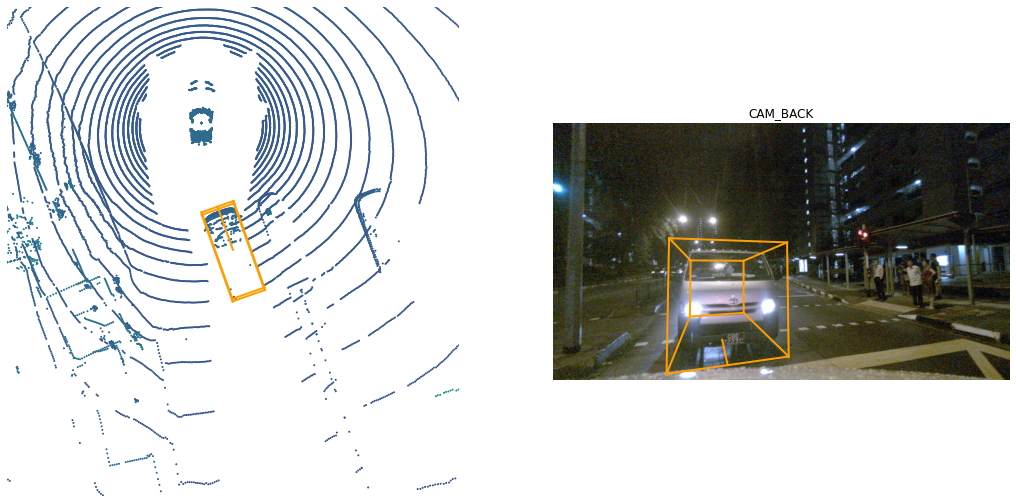

In [26]:
my_sample = nusc.get('sample', 'c631b61375a642b6b110f5bd5543ef7a')
annotation_token = my_sample['anns'][4] 
annotation_token = '1a5cfdba4e764eb7935f707e05205015'
my_annotation_metadata =  nusc.get('sample_annotation', annotation_token)
print(annotation_token)
nusc.render_annotation(annotation_token)

Obtaining the camera channel used to obtain the previously annotated object.

In [27]:
camera_channel = get_camera_data(nusc, my_annotation_metadata['token'])
camera_channel

'CAM_BACK'

Computing the 2D bounding box out of an instance, camera's sample data, and used channel.

In [28]:
sensor_laser = 'LIDAR_TOP'
# Sample data from ca Sensor
cam_data = nusc.get('sample_data', my_sample['data'][camera_channel])
# Sample data from point Sensor
point_data = nusc.get('sample_data', my_sample['data'][sensor_laser])

# Obtaining box
new_box = target_to_cam(nusc, point_data['token'], annotation_token, pointsensor_channel = sensor_laser)
print('The target 3D bouding box wrt to LiDAR is: \n{}'.format(new_box))

The target 3D bouding box wrt to LiDAR is: 
label: nan, score: nan, xyz: [1.63, -6.60, -1.08], wlh: [1.75, 4.74, 1.84], rot axis: [-0.03, 0.03, -1.00], ang(degrees): -109.62, ang(rad): -1.91, vel: nan, nan, nan, name: vehicle.car, token: 1a5cfdba4e764eb7935f707e05205015


Computing the 2D bounding box out of the interest instance

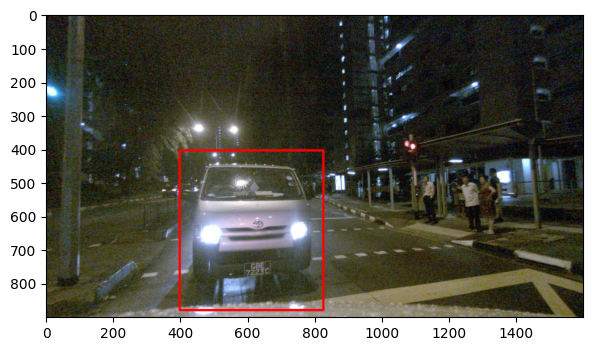

The 2d coordinates are: 
(398.56983554591335, 403.9215800706292, 826.7425129487317, 879.1987248762634)


In [29]:
coords = bbox_3d_to_2d(nusc, camera_token = cam_data['token'], annotation_token = annotation_token, 
                       visualize = True)
print('The 2d coordinates are: \n{}'.format(coords))

Computing the point cloud of the interest instance.

The shape of the points in the image are: (3, 872)
The shape of the depths in the image are: (872,)
The shape of the original points in the camera frame are: (3, 872)


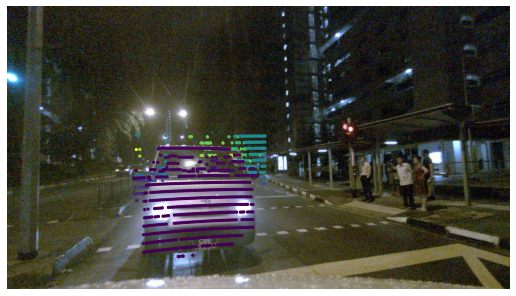

In [30]:
# Method to map a point cloud to a particular bounding box
points, coloring, ori_points, im = map_pointcloud_to_image_(nusc, coords, point_data['token'], 
                                                            cam_data['token'], dist_thresh = 0.1, visualize = True)
# Points in current image frame
print('The shape of the points in the image are: {}'.format(points.shape))
# Depths of the points in the image frame
print('The shape of the depths in the image are: {}'.format(coloring.shape))
# Filtered points in camera coordinates
print('The shape of the original points in the camera frame are: {}'.format(ori_points.shape))

## Loop to obtain all the interest objects (instances) of the dataset

The next loop will sample all the annotations of interest from the dataset and save them in the desired path.

In [9]:
# Point sensor which will be used by default
sensor_laser = 'LIDAR_TOP'

# Number of samples which will be used to loop
n_samples = np.array(nusc.sample).shape

# Pointclouds in LiDAR frame in .txt folder path
pc_folder = os.getcwd() + '/dataset/ann_points_lidar/'

# Sample JSON in .txt folder path
sample_folder = os.getcwd() + '/dataset/samples/'

# Pointclouds in camera frame folder path
img_pc_folder = os.getcwd() + '/dataset/ann_points_cam/'

# Instance pointcloud segmented folder path
pcd_segmentation_path =  os.getcwd() + '/dataset/pcd_segmentation/'

# Instance Pointcloud features folder path
point_features_path = os.getcwd() + '/dataset/point_features/'

# List to store avg proccessing time
proc_times = []

for sample_idx in tqdm(range(n_samples[0]), desc = "Sample files"):
    
    # Obtain current sample
    current_sample = nusc.sample[sample_idx]
    
    # Sample data from Laser Sensor
    point_data = nusc.get('sample_data', current_sample['data'][sensor_laser])
    
    # Obtaining all the tokens of the annotations in the current sample
    annotations = current_sample['anns']
    
    # Create dictionary to store all the annotation info in JSON for each sample
    data_json = {}
    data_json['instance'] = []
    
    # Loop over all the annotations
    for ann in annotations:
        # Obtain current annotation
        annotation_metadata =  nusc.get('sample_annotation', ann)
        
        category_name = annotation_metadata['category_name'].split('.')[0]
        
        # Start counting
        start = time.time()
        
        # If the annotation is not totally visible or the label is not vehicle
        if (int(annotation_metadata['visibility_token']) < 4 or category_name != 'vehicle'): 
            continue
        
        # Obtain the camera channel
        camera_channel = get_camera_data(nusc, annotation_metadata['token'])
        
        # Extract the sample_data giving the interest camera
        cam_data = nusc.get('sample_data', current_sample['data'][camera_channel])
        
        # Additional filter to detect if the frame is a keyframe
        if cam_data['is_key_frame'] != True:
            continue
        
        # Obtain the target for the given instance 
        target_box = target_to_cam(nusc, point_data['token'], ann, pointsensor_channel = sensor_laser)
                
        # Compute the 2d bounding box of the current annotation
        bbox = bbox_3d_to_2d(nusc, camera_token = cam_data['token'], annotation_token = ann, visualize = False)
        
        # Break the loop if the bbox is not intersected with the current image channel
        if bbox is None:
            continue
                
        # Map the velo pointcloud to the interest instance
        points, coloring, ori_points, im = map_pointcloud_to_image_(nusc, bbox, point_data['token'], 
                                                                    cam_data['token'], dist_thresh = 0.08,
                                                                    visualize = False)
        # Finish the time counter
        end = time.time()
        proc_times.append(end - start)
        
        # If the pointcloud is empty or there are less than 20 points, continue
        if np.array(ori_points).shape[1] == 0 or np.array(ori_points).shape[1] < 100:
            continue        
        
        # Dataroot for PointCloud .txt file using the annotation token
        pc_path = pc_folder + 'pc_anno_' + annotation_metadata['token'] + '.txt'
        
        # save the Pointcloud in a .txt file
        save_to_txt(pc_path, ori_points)
        
        # Dataroot for PointCloud in camera frame .txt file using the annotation token
        img_pc_path = img_pc_folder + 'img_pc_anno_' + annotation_metadata['token'] + '.txt'
        
        #  PointCloud in camera frame plus coloring row
        points_coloring = np.vstack([points, np.transpose(coloring)])
        
        # save the PointCloud in camera frame plus coloring row in a .txt file
        save_to_txt(img_pc_path,points_coloring)
        
        # Append the information for each annotation
        data_json['instance'].append({
            'annotation_token': annotation_metadata['token'],
            'sample_token' : current_sample['token'],
            'camera_token' : current_sample['data'][camera_channel],
            'pointcloud_path': pc_path,
            'pcl_shape': np.array(ori_points).shape,
            'img_pc_path': img_pc_path,
            'img_pcl_shape': np.array(points_coloring).shape,
            'pcd_path': pcd_segmentation_path+'pcd_segmentation_'+annotation_metadata['token']+'.pcd',
            'point_features_path': point_features_path+'pcd_segmentation_'+annotation_metadata['token']+'.txt',
            'position_coord': [target_box.center[0], target_box.center[1], target_box.center[2]],
            'wlh_values': annotation_metadata['size'],
            'orientation_value': target_box.orientation.degrees,
            'rotation_axis': target_box.orientation.axis[2],
            'category': category_name
        })

    file_name= 'sample_'+ current_sample['token'] + '_file.txt'
    # Save the dictionary in a .txt file in JSON format for each sample       
    save_in_file(sample_folder + file_name, data_json)    
    
print('The avg proccessing time is: {}'.format(sum(proc_times) / len(proc_times)))
print('The minimum proccessing time was: {}'.format(min(proc_times)))
print('The maximum proccessing time was: {}'.format(max(proc_times)))

Sample files: 100%|██████████| 404/404 [08:15<00:00,  1.23s/it]

The avg proccessing time is: 0.10667195430643801
The minimum proccessing time was: 0.04707455635070801
The maximum proccessing time was: 0.5529046058654785


## Visualizing the last point cloud obtained

In [31]:
def custom_draw_geometry_with_key_callback(pcd):
    
    def change_background_to_black(vis):
        opt = vis.get_render_option()
        opt.background_color = np.asarray([0, 0, 0])
        return False

    def load_render_option(vis):
        vis.get_render_option().load_from_json(
            "../../TestData/renderoption.json")
        return False

    def capture_depth(vis):
        depth = vis.capture_depth_float_buffer()
        plt.imshow(np.asarray(depth))
        plt.show()
        return False

    def capture_image(vis):
        image = vis.capture_screen_float_buffer()
        plt.imshow(np.asarray(image))
        plt.show()
        return False
    vis = o3d.visualization.Visualizer()
    key_to_callback = {}
    key_to_callback[ord("K")] = change_background_to_black
    key_to_callback[ord("R")] = load_render_option
    key_to_callback[ord(",")] = capture_depth
    key_to_callback[ord(".")] = capture_image
    o3d.visualization.draw_geometries_with_key_callbacks([pcd], key_to_callback)

In [ ]:
# Plotting the segmented point cloud
Velopoints = np.asarray(ori_points.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)
pcd.colors = o3d.utility.Vector3dVector(np.zeros((Velopoints.shape)))

# visualizing the 3D point cloud
#o3d.visualization.draw_geometries([pcd])

# press 'K' to change background color
custom_draw_geometry_with_key_callback(pcd)

In [21]:
pcl_path = osp.join(nusc.dataroot, point_data['filename']) 
pc = LidarPointCloud.from_file(pcl_path)
pts = pc.points[:-1, :]

Velopoints = np.asarray(pts.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
#o3d.visualization.draw_geometries([pcd])

# press 'K' to change background color
custom_draw_geometry_with_key_callback(pcd)